In [1]:
import csv
import tensorflow as tf
import numpy as np
import os
import re
import random
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# !unzip /data.zip -d /tmp/

In [3]:
vocab_size = 25000 #25000 default
embedding_dim = 1
max_length = 20 #num of words; sentences padded with 0s if smaller
trunc_type='post' #truncate at the end
padding_type='post' #padding at the end
oov_tok = "<OOV>"
training_portion = .99  #80% training 20 testing

# Train text and music as text (by measure end ';'  )

In [5]:
sep_sent = '\.|!|\?|\.\.\.|…|;' #separate by punctuation or num of words
sep_phrases = '\.|!|\?|\.\.\.|…|,|:|;|-|—|"|\'|&'
sep_number = 20

In [6]:
def get_sentences(text, separator, max_len=120):
    sentences = []
    if isinstance(separator, int):
        #words = [*filter(lambda word: word not in stopwords, re.split('[^a-zа-я]+', text.lower()))] #uncomment to sanitise text
        words = re.split('[^a-zа-я0-9]+', text.lower())
        for i in range(0, len(words), separator):
            sentences.append(' '.join(words[i:i + separator]))
    else:
        for sent in re.split(separator, text.lower()):
            sent=list(re.split('[^a-zа-я0-9]+', sent ))
            if len(sent)<=max_len:
                sentences.append(sent)
    return sentences

In [7]:
def walk_fs(folder):
    for label in os.listdir(folder):
        p = os.path.join(folder, label)
        if os.path.isdir(p):
            for file in os.listdir(p):
                file_path = os.path.join(p, file)
                with open(file_path, 'r',  encoding='utf-8', errors='ignore') as f:
                    yield label, file, f.read()

In [8]:
def get_labels_and_sentences(folder, get_patterns):
    labels = []
    sentences = []

    for label, _, text in walk_fs(folder):
        for sentence in get_patterns(text):
            labels.append(label)
            sentences.append(sentence)
    ls_list = list(zip(labels, sentences))
    random.shuffle(ls_list)
    return zip(*ls_list)

In [9]:
# Music
separator = sep_sent #separate by measures or number of chords
func = lambda text: get_sentences(text, separator, max_len=20)
train_labels, train_sentences = get_labels_and_sentences('text_train', func)
predict_labels, predict_sentences = get_labels_and_sentences('text_train', func)

# Train text and music as JSON (split by number or by measure)

In [4]:
def get_music_seqs(text, max_len):
    chords = []
    for measure in json.loads(text):
        chords.extend(measure)
    parts = []
    for i in range(0, len(chords), max_len):
        parts.append(' '.join(chords[i:i + max_len]))
    print('parts=', parts)
    return parts

In [5]:
def walk_fs(folder):
    for label in os.listdir(folder):
        p = os.path.join(folder, label)
        if os.path.isdir(p):
            for file in os.listdir(p):
                file_path = os.path.join(p, file)
                with open(file_path, 'r',  encoding='utf-8', errors='ignore') as f:
                    yield label, file, f.read()

In [6]:
def get_labels_and_sentences(folder, get_patterns):
    labels = []
    sentences = []

    for label, file, text in walk_fs(folder):
        print('label=',label)
        print("file=",file)
        print('text=',text)
        for sentence in get_patterns(text):
            labels.append(label)
            sentences.append(sentence)
    ls_list = list(zip(labels, sentences))
    print('ls_list=',ls_list)
    random.shuffle(ls_list)
    print('ls_list_rand=',ls_list)
    return zip(*ls_list)

In [37]:
# music
func = lambda text: get_sentences(text, max_len=120)
train_labels, train_sentences = get_labels_and_sentences('music/train_txt', func)
predict_labels, predict_sentences = get_labels_and_sentences('music/train_txt', func)

In [10]:
# music
func = lambda text: get_sentences(text, max_len=100)
train_labels, train_sentences = get_labels_and_sentences('json_train', func)
predict_labels, predict_sentences = get_labels_and_sentences('json_train', func)

In [13]:
"""MUSIC JSON by measure""" #split JSON by measure
train_labels = []
train_sentences = []

folder = 'json_train'
for label in os.listdir(folder):
    p = os.path.join(folder, label)
    if os.path.isdir(p):
        for file in os.listdir(p):
            file = os.path.join(p, file)
            with open(file, 'r',  encoding='utf-8', errors='ignore') as f:
                for sentence in json.loads(f.read()):
                    train_labels.append(label)
                    train_sentences.append(sentence)
####################                    
train_zip = zip(train_labels, train_sentences)  # see end page for refresh on zip/shuffle
train_zip_list = list(train_zip)
random.shuffle(train_zip_list) #uncomment to RANDOM shuffle data
train_labels_tuple, train_sentences_tuple = zip(*train_zip_list)
train_labels = list(train_labels_tuple)
train_sentences = list(train_sentences_tuple)
predict_sentences = train_sentences
predict_labels = train_labels
###################################
# print("train_zip_list=", train_zip_list)

training_portion = 0.99
train_size = int(len(train_sentences) * training_portion)

validation_sentences = train_sentences[train_size:]
validation_labels = train_labels[train_size:]

train_sentences = train_sentences[:train_size]
train_labels = train_labels[:train_size]

# Tokenisation

In [10]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
#print(word_index)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(train_padded[0].shape)
print(type(train_padded[0]))
btext= train_padded[0] #for testing prediction below
print(len(train_sequences[0]))
print(len(train_padded[0]))
print('train_sequences[0]=', train_sequences[0])
print('\n')
print('train_padded[0]=', train_padded[0])

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

(20,)
<class 'numpy.ndarray'>
11
20
train_sequences[0]= [23868, 5, 4, 16, 2701, 11, 18, 14829, 19, 10, 49]


train_padded[0]= [23868     5     4    16  2701    11    18 14829    19    10    49     0
     0     0     0     0     0     0     0     0]
6
20
8
20


In [11]:
validation_sequences = tokenizer.texts_to_sequences(predict_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)


68294
(68294, 20)


In [12]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels + predict_labels)
label_index = label_tokenizer.word_index
print(label_index)
print(len(label_index))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(predict_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[10])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)


{'beethoven': 1, 'mozart': 2, 'schubert': 3, 'bach': 4}
4
[1]
[4]
[3]
(68294, 1)
[3]
[2]
[2]
(68294, 1)


## Arch

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,\
Dropout, Activation, Flatten, Conv1D, MaxPooling1D,\
GlobalAveragePooling1D, Embedding, RNN, SimpleRNN

In [14]:
#RNN #the model used in experiments
num_of_output_neurons = len(label_index)+1 #n+1 classes!!!!!!!!!!!!!!!!

model = Sequential()
# model.add(tensorflow.keras.Input(shape=(250, 250, 3)))
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True, input_length=max_length))
# model.add(GlobalAveragePooling1D())
model.add(SimpleRNN( 1048, activation='relu',return_sequences=True))
model.add(Flatten())
# model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_of_output_neurons, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 1)             25000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20, 1048)          1100400   
_________________________________________________________________
flatten (Flatten)            (None, 20960)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2096100   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 3,222,005
Trainable params: 3,222,005
Non-trainable params: 0
_________________________________________________________________


# Start training

In [15]:
num_epochs = 20
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 68294 samples, validate on 68294 samples
Epoch 1/20
68294/68294 - 32s - loss: 1.0776 - accuracy: 0.5440 - val_loss: 0.9139 - val_accuracy: 0.6273
Epoch 2/20
68294/68294 - 30s - loss: 0.8609 - accuracy: 0.6594 - val_loss: 0.7299 - val_accuracy: 0.7269
Epoch 3/20
68294/68294 - 30s - loss: 0.7374 - accuracy: 0.7160 - val_loss: 0.6568 - val_accuracy: 0.7520
Epoch 4/20
68294/68294 - 30s - loss: 0.6701 - accuracy: 0.7444 - val_loss: 0.5992 - val_accuracy: 0.7739
Epoch 5/20
68294/68294 - 30s - loss: 0.6304 - accuracy: 0.7585 - val_loss: 0.5781 - val_accuracy: 0.7804
Epoch 6/20
68294/68294 - 30s - loss: 0.5985 - accuracy: 0.7712 - val_loss: 0.5539 - val_accuracy: 0.7892
Epoch 7/20
68294/68294 - 30s - loss: 0.5884 - accuracy: 0.7775 - val_loss: 0.5179 - val_accuracy: 0.8048
Epoch 8/20
68294/68294 - 30s - loss: 0.5536 - accuracy: 0.7871 - val_loss: 0.5027 - val_accuracy: 0.8090
Epoch 9/20
68294/68294 - 30s - loss: 0.5391 - accuracy: 0.7937 - val_loss: 0.4919 - val_accuracy: 0.8124
Epoch

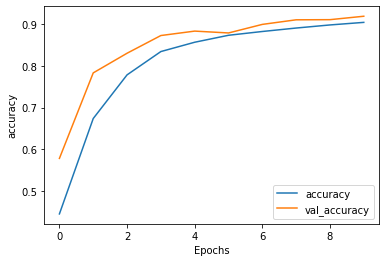

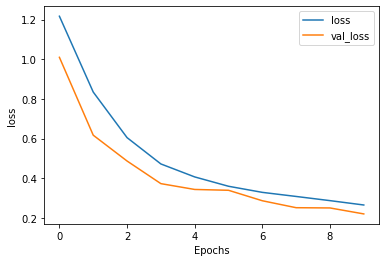

In [19]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [41]:
"""Text decoder"""
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [146]:
#btext is taken from Tokenizer code above, it's a coded text passage
print(type(btext))
print(btext)
print(btext.shape)
print(decode_sentence(btext))

<class 'numpy.ndarray'>
[4368   35   31    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   

## Prediction

In [16]:
def get_attention_words(text, max_len):
    all_words = re.split('\W+', text)
    result = []
    for i in range(0, len(all_words), max_len):
        result.append(all_words[i:i + max_len])
    return result

def walk_dir(folder):
    result = []
    for label in os.listdir(folder):
        p = os.path.join(folder, label)
        if os.path.isdir(p):
            for filename in os.listdir(p):
                file = os.path.join(p, filename)
                with open(file, 'r',  encoding='utf-8', errors='ignore') as f:
                    result.append((label, filename, f.read()))
    return result

In [18]:
def get_scores(predictions):
    scores = {}
    for prediction in predictions:
        winner_idx = np.argmax(prediction)
        scores[winner_idx] = scores.get(winner_idx, 0) + 1
    return scores

## CSV writer

In [19]:
def write_csv_from_dicts(csv_file, lines):
    with open(csv_file, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, delimiter=';', fieldnames=lines[0])
        writer.writeheader()
        for line in lines:
            writer.writerow(line)

In [20]:
def get2top_preds(scores_dict): #take a lebels with scores dict and output a list with 2 top pairs, other pairs' scores=0
    scores_list = [item for item in scores_dict.items()]
#     print(scores_list)
    scores_list2 = sorted(scores_list, key=lambda x: -x[1]) #sort scores list by the second item in pair (score), start form largest
#     print(scores_list2)

    total_top2 = scores_list2[0][1] + scores_list2[1][1]

    top2_dict = scores_dict
    for i in range(len(scores_list2)):
        if i < 2:
            top2_dict[scores_list2[i][0]] = np.around( scores_list2[i][1] / total_top2, decimals = 1) #normalise by 2 top scores
        else:
            top2_dict[scores_list2[i][0]] = 0
    top2_list = [item for item in top2_dict.items()]
    top2_list2 = sorted(top2_list, key=lambda x: -x[1])
    print('top2_list2=', top2_list2)
    top2dict = {lbl:prob for lbl, prob in top2_list2}
    return top2dict#top2_list2

In [21]:
#NORMALISED OUTPUT + CSV writer
# folder = 'literature/predict_texts_60'
# folder = 'music/predict_texts_60'
# folder = 'both_modalities/predict_texts_60'
# folder = 'both_modalities/predict_both'
folder = 'text_cuts_predict2'
count_correct = 0
count_all = 0
csv_lines=[] #initialise the list of dicts to output into CSV file
for name, filename, content in walk_dir(folder):
    sentences = get_attention_words(content, max_length)
    tokenized_sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(tokenized_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    predictions = model.predict(padded)
    scores = get_scores(predictions)
    
    print('scores=',scores)
    scores_sum = sum(scores.values()) #sum all votes
#     print('scores sum=',scores_sum)
    names = {idx: name for name, idx in label_index.items()}
    print('names=',names)
    scores_with_names = {names[key]:val for key,val in scores.items()}
    print('scores_with_names', scores_with_names)
    
    empty_dict = {names[key]:0 for key,val in names.items()} 
    scores_normalised = empty_dict #initialise the scores dict
    print('scores_normalised1=', scores_normalised)
    for key, val in scores_with_names.items(): #fill the scores dict
        scores_normalised[key] = np.around(val / scores_sum, decimals=2)
    scores_normalised = get2top_preds(scores_normalised) #TOP2!!look at 2 top picks only   
    
    
#     print('scores_normalised1=', scores_normalised)
#     scores_normalised = {names[idx]: np.around(score / scores_sum, decimals=2)  for idx, score in scores.items()} #noramlise and round scores
    print('scores_normalised=', scores_normalised)
    print('scores_normalised.items()=', scores_normalised.items())
    sorted_norm = sorted(scores_normalised.items(), key=lambda x: -x[1])
#     print('sorted_norm=', sorted_norm)

    print(name, filename[:-4])
    for label, score in sorted_norm:
        print(f'{label} -> {score}')
    winner_name = sorted_norm[0][0]
    count_all += 1
    count_correct += name == winner_name
    
    csv_dict = {'author':name, 'file':filename[:-4]} #CSV dict begins with author and text cols
    csv_dict1 = scores_normalised #CSV dict continues with scores columns
    csv_dict.update(csv_dict1)
    csv_dict['correct']= name == winner_name #CSV dict finishes with True/False column
    csv_lines.append(csv_dict)
    print('CORRECT' if name == winner_name else 'WRONG')
    print()
print(f'TOTAL: correct {count_correct} / {count_all}')



scores= {4: 13, 1: 5, 2: 4}
names= {1: 'beethoven', 2: 'mozart', 3: 'schubert', 4: 'bach'}
scores_with_names {'bach': 13, 'beethoven': 5, 'mozart': 4}
scores_normalised1= {'beethoven': 0, 'mozart': 0, 'schubert': 0, 'bach': 0}
top2_list2= [('bach', 0.7), ('beethoven', 0.3), ('mozart', 0), ('schubert', 0)]
scores_normalised= {'bach': 0.7, 'beethoven': 0.3, 'mozart': 0, 'schubert': 0}
scores_normalised.items()= dict_items([('bach', 0.7), ('beethoven', 0.3), ('mozart', 0), ('schubert', 0)])
bach Bwv0525 Sonate en trio n1_39-100sec
bach -> 0.7
beethoven -> 0.3
mozart -> 0
schubert -> 0
CORRECT

scores= {4: 16, 1: 7, 3: 2, 2: 2}
names= {1: 'beethoven', 2: 'mozart', 3: 'schubert', 4: 'bach'}
scores_with_names {'bach': 16, 'beethoven': 7, 'schubert': 2, 'mozart': 2}
scores_normalised1= {'beethoven': 0, 'mozart': 0, 'schubert': 0, 'bach': 0}
top2_list2= [('bach', 0.7), ('beethoven', 0.3), ('mozart', 0), ('schubert', 0)]
scores_normalised= {'bach': 0.7, 'beethoven': 0.3, 'mozart': 0, 'schubert'

scores= {3: 5, 1: 2, 2: 1}
names= {1: 'beethoven', 2: 'mozart', 3: 'schubert', 4: 'bach'}
scores_with_names {'schubert': 5, 'beethoven': 2, 'mozart': 1}
scores_normalised1= {'beethoven': 0, 'mozart': 0, 'schubert': 0, 'bach': 0}
top2_list2= [('schubert', 0.7), ('beethoven', 0.3), ('mozart', 0), ('bach', 0)]
scores_normalised= {'schubert': 0.7, 'beethoven': 0.3, 'mozart': 0, 'bach': 0}
scores_normalised.items()= dict_items([('schubert', 0.7), ('beethoven', 0.3), ('mozart', 0), ('bach', 0)])
schubert Moments musicaux op94 D780 n2_38-98sec
schubert -> 0.7
beethoven -> 0.3
mozart -> 0
bach -> 0
CORRECT

scores= {3: 7, 1: 2, 2: 5}
names= {1: 'beethoven', 2: 'mozart', 3: 'schubert', 4: 'bach'}
scores_with_names {'schubert': 7, 'beethoven': 2, 'mozart': 5}
scores_normalised1= {'beethoven': 0, 'mozart': 0, 'schubert': 0, 'bach': 0}
top2_list2= [('schubert', 0.6), ('mozart', 0.4), ('beethoven', 0), ('bach', 0)]
scores_normalised= {'schubert': 0.6, 'mozart': 0.4, 'beethoven': 0, 'bach': 0}
score

In [43]:
""" WRITE CSV !!!!!!!!!!!!!!!! """#####
#######################################
write_csv_from_dicts('BC_ANN.csv', csv_lines)